# Proyek Klasifikasi Gambar: KITTI Object Detection

Notebook ini mencakup pipeline lengkap untuk melatih klasifikasi gambar 'Car', 'Pedestrian', 'Cyclist', dan 'Van' menggunakan dataset KITTI.

**Fitur:**
1.  **Data Loading & Augmentation**: Menggunakan `ImageDataGenerator`.
2.  **Model Architecture**: Sequential CNN dengan `Conv2D` dan `MaxPooling`.
3.  **Training**: Menggunakan Callbacks (`EarlyStopping`, `ModelCheckpoint`).
4.  **Evaluation**: Plot Akurasi dan Loss.
5.  **Inference**: Uji coba prediksi pada data baru.
6.  **Model Conversion**: Konversi ke SavedModel, TF-Lite, dan TFJS.

---

## 1. Import Library & Konfigurasi

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

# Konfigurasi Path
BASE_DIR = 'data_split'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameter Gambar
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
TARGET_SIZE = (IMG_HEIGHT, IMG_WIDTH)

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


## 2. Data Preparation (Augmentation)

In [2]:
# Augmentasi untuk data Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation hanya di-rescale
validation_datagen = ImageDataGenerator(rescale=1./255)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical' # Multiclass (Kriteria: Dataset Splitting)
)

print("Loading Validation Data...")
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

CLASSES = list(train_generator.class_indices.keys())
print(f"Classes: {CLASSES}")

Loading Training Data...
Found 8934 images belonging to 4 classes.
Loading Validation Data...
Found 1115 images belonging to 4 classes.
Classes: ['car', 'cyclist', 'pedestrian', 'van']


## 3. Membangun Arsitektur Model (CNN)

In [3]:
model = Sequential([ # Kriteria: Model Sequential CNN
    tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    # Conv Block 1
    Conv2D(32, (3, 3), activation='relu'), # Kriteria: Conv2D Layer
    MaxPooling2D(2, 2), # Kriteria: MaxPooling Layer
    
    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), # Kriteria: MaxPooling Layer
    
    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), # Kriteria: MaxPooling Layer
    
    # Flatten & Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    # Output Layer (4 Kelas: Car, Cyclist, Pedestrian, Van)
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,035,716 (72.62 MB)

 Trainable params: 19,035,716 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Training (Dengan Callbacks)

In [4]:
# Callbacks
callbacks = [
    # Hentikan training jika val_accuracy tidak naik selama 5 epochs
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True), # Kriteria: Accuracy > 85% monitored
    # Simpan model terbaik
    tf.keras.callbacks.ModelCheckpoint('model_best.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("Starting Training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

Starting Training...
Epoch 1/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8073 - loss: 0.6300
Epoch 1: val_accuracy improved from None to 0.88879, saving model to model_best.h5



Epoch 1: finished saving model to model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 87s 308ms/step - accuracy: 0.8313 - loss: 0.5215 - val_accuracy: 0.8888 - val_loss: 0.3282
Epoch 2/10
  1/279 ━━━━━━━━━━━━━━━━━━━━ 1:46 382ms/step - accuracy: 0.9375 - loss: 0.2862
Epoch 2: val_accuracy did not improve from 0.88879
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9375 - loss: 0.2862 - val_accuracy: 0.8778 - val_loss: 0.3476
Epoch 3/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8586 - loss: 0.4071
Epoch 3: val_accuracy did not improve from 0.88879
279/279 ━━━━━━━━━━━━━━━━━━━━ 93s 332ms/step - accuracy: 0.8652 - loss: 0.3811 - val_accuracy: 0.8833 - val_loss: 0.2963
Epoch 4/10
  1/279 ━━━━━━━━━━━━━━━━━━━━ 1:53 409ms/step - accuracy: 0.9062 - loss: 0.2475
Epoch 4: val_accuracy did not improve from 0.88879
279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9062 - loss: 0.2475 - val_accuracy: 0.8824 - val_loss: 0.2917
Epoch 5/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step -


Epoch 5: finished saving model to model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 78s 280ms/step - accuracy: 0.8827 - loss: 0.3261 - val_accuracy: 0.9265 - val_loss: 0.2091
Epoch 6/10
  1/279 ━━━━━━━━━━━━━━━━━━━━ 2:03 443ms/step - accuracy: 0.9062 - loss: 0.3585
Epoch 6: val_accuracy did not improve from 0.92647
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9062 - loss: 0.3585 - val_accuracy: 0.9265 - val_loss: 0.2052
Epoch 7/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8878 - loss: 0.2892
Epoch 7: val_accuracy did not improve from 0.92647
279/279 ━━━━━━━━━━━━━━━━━━━━ 86s 308ms/step - accuracy: 0.8981 - loss: 0.2773 - val_accuracy: 0.9062 - val_loss: 0.2459
Epoch 8/10
  1/279 ━━━━━━━━━━━━━━━━━━━━ 2:11 474ms/step - accuracy: 0.8125 - loss: 0.5876
Epoch 8: val_accuracy did not improve from 0.92647
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8125 - loss: 0.5876 - val_accuracy: 0.9228 - val_loss: 0.2073
Epoch 9/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - 


Epoch 9: finished saving model to model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 79s 284ms/step - accuracy: 0.9134 - loss: 0.2429 - val_accuracy: 0.9550 - val_loss: 0.1368
Epoch 10/10
  1/279 ━━━━━━━━━━━━━━━━━━━━ 1:13 263ms/step - accuracy: 0.9062 - loss: 0.2329
Epoch 10: val_accuracy did not improve from 0.95496
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9062 - loss: 0.2329 - val_accuracy: 0.9439 - val_loss: 0.1519


## 5. Evaluasi & Visualisasi

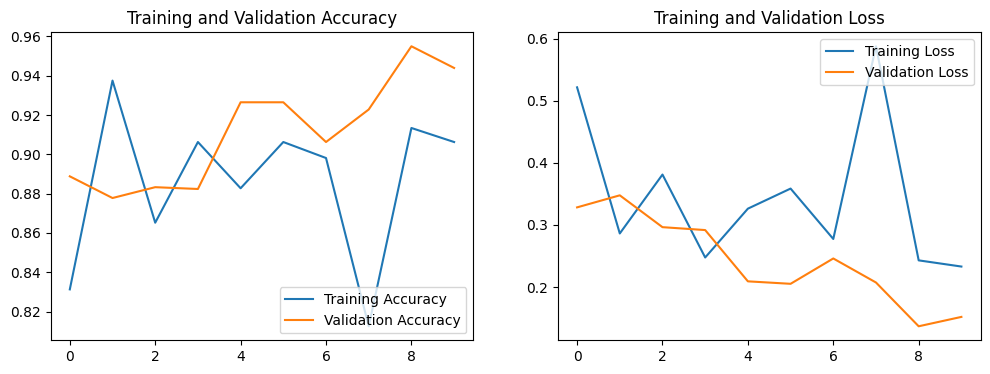

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy') # Kriteria: Plot Accuracy & Loss
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

## 6. Inference (Uji Coba)
Mengambil satu gambar acak dari folder test.

Testing on: data_split/test/cyclist/0093_055_000401.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


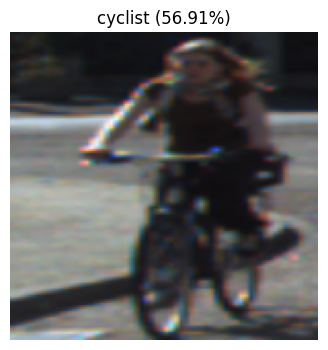

('cyclist', np.float32(0.5690746))

In [6]:
def predict_image(img_path, model, classes):
    # Load & Preprocess
    img = image.load_img(img_path, target_size=TARGET_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Predict
    predictions = model.predict(img_array)
    idx = np.argmax(predictions)
    label = classes[idx]
    confidence = predictions[0][idx]

    # Plot
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"{label} ({confidence:.2%})")
    plt.axis('off')
    plt.show()
    return label, confidence

# Ambil contoh gambar dari test set
import random
test_class = random.choice(CLASSES)
test_dir_class = os.path.join(TEST_DIR, test_class)
test_img_name = random.choice(os.listdir(test_dir_class))
test_img_path = os.path.join(test_dir_class, test_img_name)

print(f"Testing on: {test_img_path}")
predict_image(test_img_path, model, CLASSES)

## 7. Konversi Model (SavedModel, TF-Lite, TFJS)

In [7]:
# Load Model Terbaik
best_model = load_model('model_best.h5')

# 1. Save as SavedModel
output_saved_model = 'output_saved_model'
if os.path.exists(output_saved_model):
    shutil.rmtree(output_saved_model)
try:
    best_model.export(output_saved_model)
    print("✅ SavedModel exported successfully.")
except Exception as e:
    print(f"❌ SavedModel export failed: {e}")

# 2. Convert to TF-Lite
tflite_path = 'model_car_pedestrian.tflite'
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(best_model) # Kriteria: TF-Lite Conversion
    tflite_model = converter.convert()
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)
    print(f"✅ TF-Lite model saved to {tflite_path}.")
except Exception as e:
    print(f"❌ TF-Lite conversion failed: {e}")

# 3. Convert to TFJS
output_tfjs = 'output_tfjs'
if os.path.exists(output_tfjs):
    shutil.rmtree(output_tfjs)
try:
    # Patch untuk numpy compatibility di notebook
    if not hasattr(np, 'object'):
        np.object = object
    import tensorflowjs as tfjs
    tfjs.converters.convert_tf_saved_model(output_saved_model, output_tfjs) # Kriteria: TFJS Conversion
    print(f"✅ TFJS model saved to {output_tfjs}.")
except Exception as e:
    print(f"❌ TFJS conversion failed: {e}")

INFO:tensorflow:Assets written to: output_saved_model/assets


INFO:tensorflow:Assets written to: output_saved_model/assets


Saved artifact at 'output_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  4959820048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959819088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959828304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959823312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959822736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959822160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959822352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959815440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959823504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959828688: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ SavedModel exported successfully.
INFO:tensorflow:Assets writte

INFO:tensorflow:Assets written to: /var/folders/6r/c477pvvd4bjd8pd3x3sj9_br0000gn/T/tmp_iy4639t/assets


Saved artifact at '/var/folders/6r/c477pvvd4bjd8pd3x3sj9_br0000gn/T/tmp_iy4639t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  4959820048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959819088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959828304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959823312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959822736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959822160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959822352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959815440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959823504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4959828688: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1768821338.472165  477795 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1768821338.472355  477795 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
I0000 00:00:1768821338.481133  477795 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled


✅ TF-Lite model saved to model_car_pedestrian.tflite.


I0000 00:00:1768821343.286701  477795 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1768821343.287238  477795 single_machine.cc:376] Starting new session


Writing weight file output_tfjs/model.json...
✅ TFJS model saved to output_tfjs.
